# Part 8: Uplift Modeling
Maximizing the incremental return of your marketing campaigns.

One of the most critical jobs of Growth Hacker is to be efficient by all means as much as possible. First of all, you need to be time-efficient. That means you have to quickly ideate, experiment, learn and re-iterate. Second, you need to be __cost-efficient__. It means bringing the maximum return for a given budget/time/effort.

Segmentation helps Growth Hackers to increase conversion and hence be cost-efficient. But imagine a case that you are about to launch a promotional campaign and you know which segment you want to target. Do you need to send the offer to everyone?

The answer is no. In your current target group, there will be customers who are going to purchase anyways. You will cannibalize yourself by giving the promotion. We can summarize the segments based on this approach like below:
* __Treatment Responders__: Customers that will purchase only if they receive an offer
* __Treatment Non-Responders__: Customer that won’t purchase in any case
* __Control Responders__: Customers that will purchase without an offer
* __Control Non-Responders__: Customers that will not purchase if they don’t receive an offer

The picture is very obvious. 
> You need to target Treatment Responders (TR) and Control Non-Responders (CN). 

Since they won’t purchase unless you give an offer, these groups are boosting your uplift in promotional campaigns. On the other hand, you need to avoid targeting Treatment Non-Responders (TN) and Control Responders (CR). You will not benefit from targeting TN and, CN will make you cannibalize.

There is one last simple thing to do. We need to identify which customers fall into which buckets. The answer is Uplift Modeling. It has two simple steps:
1. Predict the probabilities of being in each group for all customers: we are going to build a multi-classification model for that.
1. We will calculate the uplift score. Uplift score formula is:

> `Uplift Score = Ptr + Pcn - Ptn - Pcr`

We will sum up the probability of being __TR__ and __CN__ and subtract the probability of falling into other buckets. The higher score means higher uplift.

In [1]:
from datetime import datetime, timedelta, date

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
import plotly.graph_objects as go
import plotly.figure_factory as ff

#import machine learning related libraries
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import growth_kit as gk

In [37]:
def calc_uplift(df):
    #assigning 25$ to the average order value
    avg_order_value = 25
    
    #size of groups
    base_size = len(df[df['offer'] == 'No Offer'])
    disc_size = len(df[df['offer'] == 'Discount'])
    bogo_size = len(df[df['offer'] == 'Buy One Get One'])
    
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    
    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv
    
    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df.loc[(df.offer == 'Discount'), 'conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df.loc[(df.offer == 'Buy One Get One'), 'conversion'])
    
    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value
        
    print('Total Targeted Customer Count: {0}'.format(disc_size))
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}'.format(np.round(disc_rev_uplift,2)))
    print('Revenue Uplift Per Targeted Customer: ${0}\n'.format(np.round(disc_rev_uplift/disc_size, 2)))
          
    if len(df[df.offer == 'Buy One Get One']['conversion']) > 0:
        print('-------------- \n')

        print('Total Targeted Customer Count: {0}'.format(bogo_size))
        print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
        print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
        print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))
        print('Revenue Uplift Per Targeted Customer: ${0}\n'.format(np.round(bogo_rev_uplift/bogo_size, 2)))

In [3]:
#import the data
df_data = pd.read_csv('data/response_data.csv')

#print first 10 rows
df_data.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [5]:
df_data.conversion.mean()

0.14678125

We have the data of customers who received Discount and Buy One Get One offers and how they reacted. We also have a control group that didn’t receive anything.

Column descriptions are as follows:

* __recency__: months since last purchase
* __history__: $value of the historical purchases
* __used_discount/used_bogo__: indicates if the customer used a discount or buy one get one before
* __zip_code__: class of the zip code as Suburban/Urban/Rural
* __is_referral__: indicates if the customer was acquired from referral channel
* __channel__: channels that the customer using, Phone/Web/Multichannel
* __offer__: the offers sent to the customers, Discount/But One Get One/No Offer

Before building the model, let’s apply our calc_uplift function to see the current uplift of this campaign as a benchmark:

In [6]:
calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Conversion uplift is 7.66% for discount and 4.52% for buy one get one (BOGO).
Next, we will start building our model.

## Multi-classification Model for Predicting the Uplift Score
Currently, our label is if a customer converted or not (1 or 0). We need to create four classes for TR, TN, CR, and CN. We know that the customers who received discount and bogo offers are Treatment and the rest is control. Let’s create a __campaign_group__ column make this info visible:

In [7]:
df_data['campaign_group'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'campaign_group'] = 'control'

Perfect, now we need to create our new labels:

In [8]:
df_data['target_class'] = 0 #CN
df_data.loc[(df_data.campaign_group == 'control') & (df_data.conversion > 0),'target_class'] = 1 #CR
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion == 0),'target_class'] = 2 #TN
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion > 0),'target_class'] = 3 #TR

In [13]:
df_data.target_class.value_counts().sort_index()

0    19044
1     2262
2    35562
3     7132
Name: target_class, dtype: int64

In [14]:
df_data.target_class.value_counts(normalize=True).sort_index()

0    0.297563
1    0.035344
2    0.555656
3    0.111437
Name: target_class, dtype: float64

In this example, the mapping of the classes are below:
* 0 -> Control Non-Responders
* 1 -> Control Responders
* 2 -> Treatment Non-Responders
* 3 -> Treatment Responders

There is one small feature engineering step before training our model. We will create clusters from history column and apply get_dummies for converting categorical columns into numerical:

In [9]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_data[['history']])
df_data['history_cluster'] = kmeans.predict(df_data[['history']])

#order the clusters
df_data = gk.order_cluster('history_cluster', 'history',df_data,True)

In [10]:
#creating a new dataframe as model and dropping columns that defines the label
df_model = df_data.drop(['offer','campaign_group','conversion'],axis=1)

#convert categorical columns
df_model = pd.get_dummies(df_model)

In [15]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1


Let’s fit our model and get the probabilities for each class:

In [16]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class

In [17]:
X.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'history_cluster', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web'],
      dtype='object')

In [18]:
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [19]:
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

Variable class_probs possesses the probabilities for each customer. Let’s check out an example:

In [20]:
class_probs[0]

array([0.27972656, 0.0536616 , 0.45044246, 0.21616942], dtype=float32)

For this specific customer, we can map the probabilities as below:
* CN: 28%
* CR: 5.4%
* TN: 45%
* TR: 21.6%

So the uplift score for this customer is:
> `0.28 + 0.216 - 0.054 - 0.45 = -0.008`

In [26]:
X_test['proba_CN'] = class_probs[:,0] 
X_test['proba_CR'] = class_probs[:,1] 
X_test['proba_TN'] = class_probs[:,2] 
X_test['proba_TR'] = class_probs[:,3] 

In [27]:
X_test['uplift_score'] = X_test.eval('proba_CN + proba_TR - proba_TN - proba_CR')

In [28]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
32277,1,305.09,1,1,0,1,0,1,0,0,1,0,0.279727,0.053662,0.450442,0.216169,-0.008208
12824,2,29.99,1,0,0,0,1,0,0,0,0,1,0.261329,0.069869,0.511080,0.157722,-0.161898
20159,3,77.60,1,0,1,0,1,0,0,0,1,0,0.316717,0.037487,0.556986,0.088810,-0.188947
41575,4,257.32,0,1,1,1,0,1,0,0,0,1,0.301577,0.026058,0.568334,0.104031,-0.188783
10736,7,115.10,1,0,0,0,0,1,0,0,1,0,0.304121,0.037819,0.569774,0.088287,-0.215185


Let’s apply this to all users and calculate the uplift score:

In [22]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))

In [23]:
#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]

In [24]:
#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')

In [25]:
#assign it back to main dataframe
df_data['uplift_score'] = df_model['uplift_score']

By running the code above, we added a uplift_score column in our main dataframe and it looks like below:

In [29]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment,2,0,-0.205117
1,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment,2,0,-0.159743
2,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,treatment,3,0,-0.160533
3,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0,treatment,2,0,-0.177132
4,10,32.84,0,1,Urban,1,Web,Buy One Get One,0,treatment,2,0,-0.231710


It is time to check the most critical part of having this model. Is the model really working? It is a bit hard to evaluate the true performance of uplift modeling. We will check how the uplift is changing across uplift score quantiles to see if we can use the model in real life.

In [39]:
df_data.groupby('offer').uplift_score.mean()

offer
Buy One Get One   -0.184177
Discount          -0.183667
No Offer          -0.179969
Name: uplift_score, dtype: float32

## Model Evaluation
To evaluate our model, we will create two different groups and compare them with our benchmark. Groups are:
1. High Uplift Score: Customers have uplift score > 3rd quantile
1. Low Uplift Score: Customers have uplift score < 2nd quantile

We are going to compare:
* Conversion uplift
* Revenue uplift per target customer to see if our model can make our actions more efficient.

Here is our benchmark for the discount campaign.

In [38]:
calc_uplift(df_data[df_data['offer'] != 'Buy One Get One'])

Total Targeted Customer Count: 21307
Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35
Revenue Uplift Per Targeted Customer: $1.91



### Evaluation on the whole dataset
Including observations on which model was trained. Carefull! This shows performance better than actual.

Let’s create the first group and see the numbers:

In [40]:
df_data_lift = df_data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)


In [41]:
len(df_data_lift)

10865

In [42]:
calc_uplift(df_data_lift)

Total Targeted Customer Count: 5268
Discount Conversion Uplift: 12.09%
Discount Order Uplift: 637.02
Discount Revenue Uplift: $15925.59
Revenue Uplift Per Targeted Customer: $3.02



The results are great. Revenue uplift per target customer is __57%__ better and we can easily see that __25%__ of the target group is contributing to __40%__ of the revenue uplift.

We will check the same numbers for the group with the lower uplift score:

In [53]:
df_data_lift = df_data.copy()
uplift_q_50 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_50)].reset_index(drop=True)

In [54]:
#calculate the uplift
calc_uplift(df_data_lift)

Total Targeted Customer Count: 10778
Discount Conversion Uplift: 5.83%
Discount Order Uplift: 628.17
Discount Revenue Uplift: $15704.3
Revenue Uplift Per Targeted Customer: $1.46



As expected, revenue uplift per targeted customer decreased to __$1.4__. Moreover, the group is __50%__ of the targeted customers contributed to __37%__ of the revenue uplift.

By using this model, we can easily make our campaign more efficient by:
* Targeting specific segments based on the uplift score
* Trying different offers based on customer’s uplift score

### Evaluation on the X_test dataset
This is real evalustion of results only on the test dataset. It evaluates the model perfomance (which is bad) and thus fails to demonstrate how uplift modeling impacts the revenue.

Let’s create the first group and see the numbers:

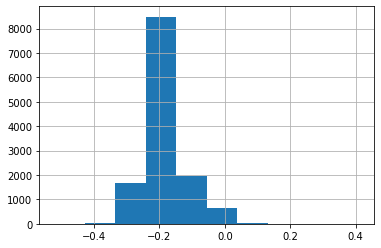

In [81]:
X_test.uplift_score.hist()

In [70]:
X_test.shape

(12800, 17)

In [73]:
df_data_lift = df_data.iloc[X_test.index, :].copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)


In [74]:
len(df_data_lift)

2132

In [75]:
calc_uplift(df_data_lift)

Total Targeted Customer Count: 1087
Discount Conversion Uplift: 7.9%
Discount Order Uplift: 85.85
Discount Revenue Uplift: $2146.15
Revenue Uplift Per Targeted Customer: $1.97



The results in the top 0.75 quantile are slightly better compared to the benchmark. But our model does not discriminate well the users.

We will check the same numbers for the group with the lower uplift score (below 0.5 quantile):

In [76]:
df_data_lift = df_data.iloc[X_test.index, :].copy()
uplift_q_50 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_50)].reset_index(drop=True)

In [77]:
#calculate the uplift
calc_uplift(df_data_lift)

Total Targeted Customer Count: 2135
Discount Conversion Uplift: 7.07%
Discount Order Uplift: 150.97
Discount Revenue Uplift: $3774.19
Revenue Uplift Per Targeted Customer: $1.77



Revenue uplift per targeted customer in lower 0.5 quantile decreased compared to the benchmark, but not drasticaly. Fitted model cannot discriminate well users that we want to target with promotional campaigns.